In [1]:
pip install agml


Note: you may need to restart the kernel to use updated packages.


In [2]:
import agml.data as data
print(dir(data))


['AgMLDataLoader', 'ImageLoader', 'PointCloud', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'builder', 'coco_to_bboxes', 'convert_bbox_format', 'download_public_dataset', 'experimental', 'exporters', 'extensions', 'image_loader', 'loader', 'manager', 'managers', 'metadata', 'object', 'point_cloud', 'public', 'public_data_sources', 'source', 'tools']


In [3]:
from agml.data import download_public_dataset

download_public_dataset('plant_village_classification')


/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
05-20-2025 07:19:22 WARNING - root: [AgML] Dataset 'plant_village_classification' already exists in '/home/itartoussi/.agml/datasets/plant_village_classification', skipping download.


'/home/itartoussi/.agml/datasets'

Total samples: 55448


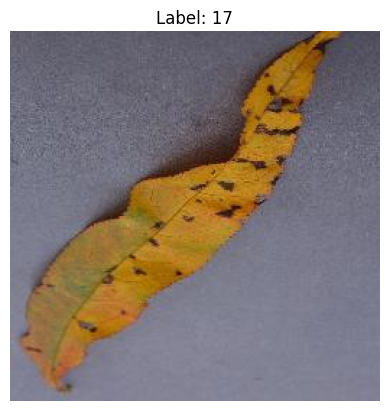

In [4]:
from agml.data import AgMLDataLoader

loader = AgMLDataLoader('plant_village_classification')

print("Total samples:", len(loader))

# Example: show first image and label
import matplotlib.pyplot as plt

image, label = loader[0]
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [5]:
import torch
print(torch.__version__)


2.5.1


In [6]:
from agml.data import AgMLDataLoader

loader = AgMLDataLoader('plant_village_classification')


In [7]:
import torch
import torch.nn as nn


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(x_cat))
        return x * attention


In [8]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

class MobileNetV2WithSA(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2WithSA, self).__init__()
        self.mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        self.spatial_attention = SpatialAttention()
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.mobilenet.features(x)          # Backbone features
        x = self.spatial_attention(x)           # Apply Spatial Attention
        x = x.mean([2, 3])                       # Global Average Pooling
        x = self.classifier(x)                  # Classification
        return x


In [12]:
from collections import Counter

label_counter = Counter()
for _, label in loader:
    label_counter[label] += 1

print(f"Number of classes: {len(label_counter)}")
print(label_counter)


Number of classes: 39
Counter({16: 5507, 36: 5357, 25: 5090, 17: 2297, 29: 2127, 31: 1909, 26: 1835, 33: 1771, 34: 1676, 3: 1645, 38: 1591, 5: 1502, 20: 1478, 35: 1404, 13: 1383, 9: 1192, 12: 1180, 11: 1162, 4: 1143, 27: 1109, 14: 1076, 6: 1052, 22: 1000, 21: 1000, 30: 1000, 19: 997, 10: 985, 32: 952, 7: 854, 0: 630, 1: 621, 8: 513, 28: 456, 15: 423, 37: 373, 24: 371, 18: 360, 2: 275, 23: 152})


Total samples: 55448
Number of classes: 39


05-20-2025 07:42:45 WARNING - matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94592464].


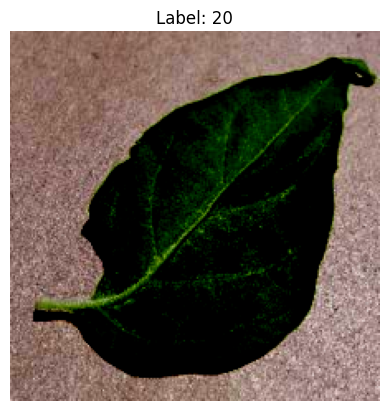

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from agml.data import AgMLDataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# التحميل من AgML
agml_loader = AgMLDataLoader('plant_village_classification')

# عدد الكلاسات
num_classes = len(set(label for _, label in agml_loader))
print(f"Total samples: {len(agml_loader)}")
print(f"Number of classes: {num_classes}")

# التحويل إلى Dataset مخصص
class AgMLTorchDataset(Dataset):
    def __init__(self, agml_loader, transform=None):
        self.agml_loader = agml_loader
        self.transform = transform

    def __len__(self):
        return len(self.agml_loader)

    def __getitem__(self, idx):
        image, label = self.agml_loader[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformات للصورة
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # مناسب لموديلات مثل MobileNet
    transforms.Normalize(mean=[0.5], std=[0.5])  # تقدر تعدلها حسب بياناتك
])

# تجهيز الداتا
full_dataset = AgMLTorchDataset(agml_loader, transform=transform)

# Split إلى train/test بنسبة 80/20
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# تأكد من أن كل شيء يعمل بعرض صورة من الـ train loader
sample_img, sample_label = next(iter(train_loader))
plt.imshow(sample_img[0].permute(1, 2, 0))  # من (C, H, W) إلى (H, W, C)
plt.title(f"Label: {sample_label[0].item()}")
plt.axis('off')
plt.show()


In [17]:
import torch
import torch.nn as nn
from torchvision import models  # انت استوردت models

# عدد الكلاسات
NUM_CLASSES = 39  # غير الرقم حسب بياناتك

# تحميل MobileNetV2 مع الأوزان
from torchvision.models import MobileNet_V2_Weights
weights = MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights)  # استعمل models وليس torchvision.models

# تجميد الميزات (اختياري)
for param in model.features.parameters():
    param.requires_grad = True

# تعديل الطبقة الأخيرة للتصنيف
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, NUM_CLASSES)
)

# إرسال إلى الجهاز المناسب
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



In [15]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [3]:
import os

base_path = '/home/itartoussi/.agml/datasets/plant_village_classification'
print(os.listdir(base_path))


['Grape___healthy', 'Apple___Cedar_apple_rust', 'Blueberry___healthy', 'Strawberry___healthy', 'Pepper,_bell___Bacterial_spot', 'Apple___healthy', 'Tomato___Early_blight', 'Tomato___Bacterial_spot', 'Raspberry___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Pepper,_bell___healthy', 'Apple___Apple_scab', 'Peach___healthy', 'Grape___Esca_(Black_Measles)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Corn___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Squash___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Background_without_leaves', 'Apple___Black_rot', 'Corn___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Grape___Black_rot', 'Corn___Common_rust', 'Potato___healthy', 'Tomato___Leaf_Mold', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Peach___Bacterial_spot', 'Tomato___healthy', 'Soybean___heal

In [4]:
original_dataset_dir = '/home/itartoussi/.agml/datasets/plant_village_classification'


In [5]:
import os
import shutil
import random

original_dataset_dir = '/home/itartoussi/.agml/datasets/plant_village_classification'
base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

split_ratio = 0.8

for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_point = int(len(images) * split_ratio)
    train_imgs = images[:split_point]
    val_imgs = images[split_point:]

    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for img_name in train_imgs:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(train_class_dir, img_name)
        shutil.copy2(src, dst)

    for img_name in val_imgs:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(val_class_dir, img_name)
        shutil.copy2(src, dst)

print("✅ تم تقسيم الصور بنجاح إلى train و val")


✅ تم تقسيم الصور بنجاح إلى train و val


In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# التحويلات (مع إمكانية إضافة augmentations لاحقاً)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# تحميل البيانات
train_dataset = datasets.ImageFolder(root='dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset_split/val', transform=transform)

# إنشاء dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# عدد الكلاسات
NUM_CLASSES = len(train_dataset.classes)
print(f"عدد الكلاسات: {NUM_CLASSES}")


عدد الكلاسات: 39


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# ✅ إعدادات عامة
NUM_CLASSES = 39
BATCH_SIZE = 32
NUM_EPOCHS = 100

# ✅ تحميل MobileNetV2 وتعديل الطبقة النهائية
weights = MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights)

in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, NUM_CLASSES)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ✅ الخسارة والمُحسّن والجدولة
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# ✅ التحويلات
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ تحميل البيانات
train_dataset = datasets.ImageFolder('dataset_split/train', transform=train_transforms)
val_dataset = datasets.ImageFolder('dataset_split/val', transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ✅ التدريب والتقييم
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    scheduler.step()
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # ✅ التقييم على validation
    model.eval()
    val_correct, val_total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")


Epoch 1/100: 100%|██████████| 1386/1386 [24:08<00:00,  1.05s/it]


Epoch [1/100], Loss: 413.3044, Train Accuracy: 0.9083
Validation Accuracy: 0.9359


Epoch 2/100: 100%|██████████| 1386/1386 [24:56<00:00,  1.08s/it]


Epoch [2/100], Loss: 194.8804, Train Accuracy: 0.9553
Validation Accuracy: 0.9543


Epoch 3/100: 100%|██████████| 1386/1386 [24:53<00:00,  1.08s/it]


Epoch [3/100], Loss: 157.6985, Train Accuracy: 0.9635
Validation Accuracy: 0.9709


Epoch 4/100: 100%|██████████| 1386/1386 [25:01<00:00,  1.08s/it]


Epoch [4/100], Loss: 130.7531, Train Accuracy: 0.9703
Validation Accuracy: 0.9656


Epoch 5/100:  92%|█████████▏| 1281/1386 [23:02<01:50,  1.05s/it]